# Enhanced Document Language Detection
This notebook demonstrates the approach to language detection using an advanced embedding-based approach, compared with a classical `Multinomial Naive Bayes` classifier method and a model based on the 'XLM-RoBERTa-base' model. We will utilize the `intfloat/multilingual-e5-large-instruct` model, and benchmark its results on the `papluca/language-identification` language detection dataset. Finally, we will conclude and discuss the obtained results, strengths and limitations of the three approaches, and possible directions for future work.

We will begin by setting up the environment and importing the necessary libraries.


In [1]:
!nvidia-smi

Sat Oct 19 13:47:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q datasets sentence-transformers numpy matplotlib seaborn pandas scikit-learn torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00


In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import shutil
from google.colab import files

from datasets import load_dataset, concatenate_datasets
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
from torch.utils.data import DataLoader
from transformers import pipeline
import torch

# For classical ML model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Setting up matplotlib for high-quality plots
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


<ipython-input-3-a009dd44b595>:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data Loading and Preparation
We will load the dataset using the `datasets` library, which provides an easy-to-use interface to access the `papluca/language-identification` dataset. This dataset contains text samples in 20 different languages. We will concatenate the training and validation sets for embedding computation.


In [4]:
def load_and_prepare_data():
    ds = load_dataset("papluca/language-identification")
    train_valid_dataset = concatenate_datasets([ds['train'], ds['validation']])
    label_names = sorted(set(ds['train']['labels']))
    return ds, train_valid_dataset, label_names

# Load the dataset
ds, train_valid_dataset, label_names = load_and_prepare_data()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.99k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Visualizing Label Distribution
To understand the dataset better, we will visualize the label distribution across different dataset splits. This will give us an insight into the balance of classes, which is important for model performance.


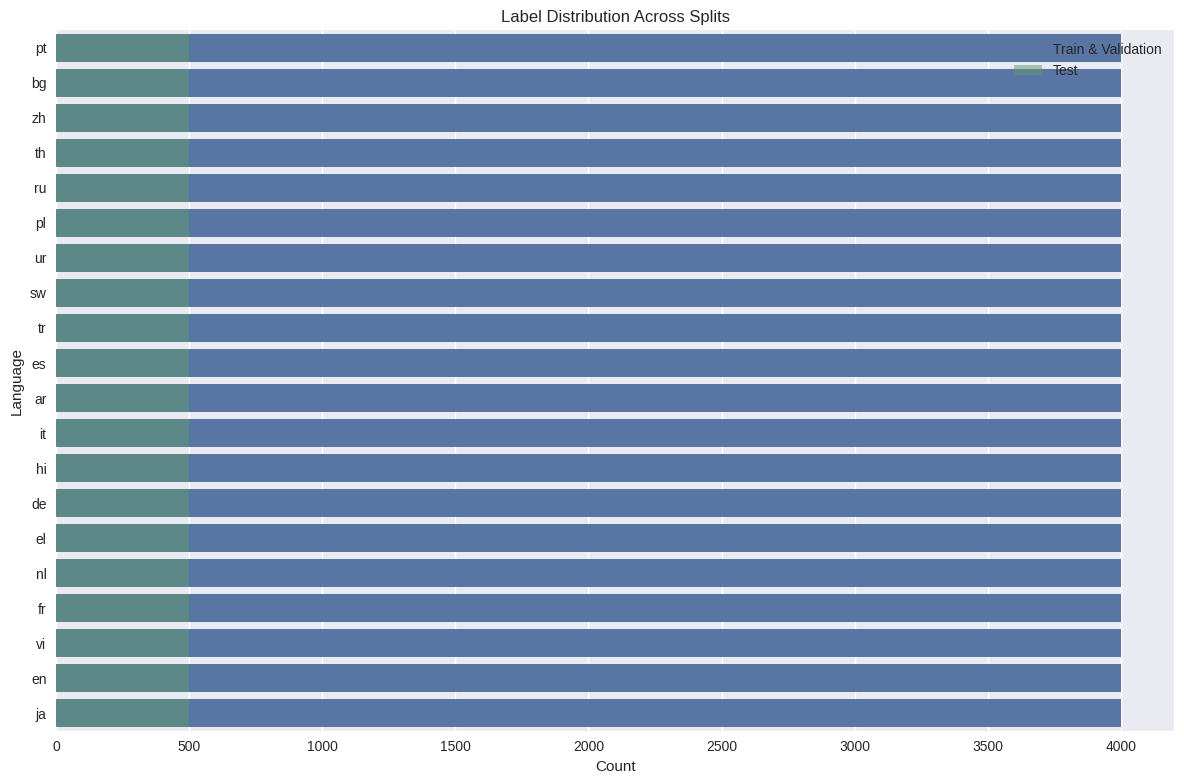

In [5]:
def visualize_label_distribution(dataset):
    plt.figure(figsize=(12, 8))

    # Combine train and validation splits
    combined_df = pd.concat([dataset['train'].to_pandas(), dataset['validation'].to_pandas()])

    sns.countplot(y='labels', data=combined_df, order=combined_df['labels'].value_counts().index, label='Train & Validation')

    # Plot test split separately
    sns.countplot(y='labels', data=dataset['test'].to_pandas(), order=dataset['test'].to_pandas()['labels'].value_counts().index, label='Test', alpha=0.5)  # Use alpha for transparency

    plt.title("Label Distribution Across Splits")
    plt.xlabel("Count")
    plt.ylabel("Language")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize the label distribution
visualize_label_distribution(ds)

## Language Detector Class
We encapsulate the model's functionality within a `LanguageDetector` class. This class will handle embedding computation, prediction, and evaluation. The embeddings will be stored and reused to optimize computational efficiency.


In [6]:
class LanguageDetector:
    def __init__(self, model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = SentenceTransformer(model_name).to(device)
        self.device = device
        self.avg_embeddings = None
        self.label_names = None

    def compute_embeddings(self, dataset, label_names, split_name, batch_size=32, embedding_dir='./embeddings'):
        self.label_names = label_names
        avg_embeddings_path = os.path.join(embedding_dir, f'{split_name}_avg_embeddings.npy')

        if os.path.exists(avg_embeddings_path):
            print(f"Loading average embeddings from {avg_embeddings_path}")
            self.avg_embeddings = np.load(avg_embeddings_path, allow_pickle=True).item()
        else:
            print(f"Computing and saving embeddings to {embedding_dir}")
            embeddings = {label: [] for label in label_names}
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            for batch in tqdm(dataloader, desc=f"Encoding {split_name} batches"):
                texts = batch['text']
                labels = batch['labels']
                formatted_texts = [f"Instruct: Identify the language of the following text.\nQuery: {text}" for text in texts]
                batch_embeddings = self.model.encode(formatted_texts, convert_to_tensor=True, device=self.device)

                for embedding, label in zip(batch_embeddings, labels):
                    label_dir = os.path.join(embedding_dir, label)
                    os.makedirs(label_dir, exist_ok=True)
                    embedding_file = os.path.join(label_dir, f'embedding_{len(embeddings[label])}.npy')
                    np.save(embedding_file, embedding.cpu().numpy())
                    embeddings[label].append(embedding.cpu().numpy())

            self.avg_embeddings = {label: np.mean(np.stack(embeds), axis=0) for label, embeds in embeddings.items()}
            np.save(avg_embeddings_path, self.avg_embeddings)

    def predict(self, texts):
        if not isinstance(texts, list):
            texts = [texts]

        formatted_texts = [f"Instruct: Identify the language of the following text.\nQuery: {text}" for text in texts]
        embeddings = self.model.encode(formatted_texts, convert_to_tensor=True, device=self.device)

        predictions = []
        for embedding in embeddings:
            similarities = {label: cosine_similarity([embedding.cpu().numpy()], [self.avg_embeddings[label]])[0][0]
                            for label in self.label_names}
            pred_label = max(similarities, key=similarities.get)
            predictions.append(pred_label)

        return predictions if len(predictions) > 1 else predictions[0]

    def evaluate(self, test_dataset, batch_size=32):
        true_labels = []
        pred_labels = []

        dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        for batch in tqdm(dataloader, desc="Evaluating batches"):
            texts = batch['text']
            labels = batch['labels']
            predictions = self.predict(texts)
            true_labels.extend(labels)
            pred_labels.extend(predictions)

        overall_accuracy = accuracy_score(true_labels, pred_labels)
        report = classification_report(true_labels, pred_labels, target_names=self.label_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        support = {label: true_labels.count(label) for label in self.label_names}
        report_df['support'] = pd.Series(support)
        report_df = report_df.round(3)
        average_f1_score = f1_score(true_labels, pred_labels, average='weighted')

        return overall_accuracy, average_f1_score, report_df, true_labels, pred_labels


## Initializing and Calculating Embeddings using the E5 Model
In this section, we initialize the `LanguageDetector` class using the `intfloat/multilingual-e5-large-instruct` model.
This model will be used to compute embeddings for the training and validation dataset, which will then be averaged for each language.
These averaged embeddings will serve as reference points during the inference phase, where the model will determine the language of new input texts based on cosine similarity.


In [7]:
# Initialize and train the E5 model
detector_e5 = LanguageDetector('intfloat/multilingual-e5-large-instruct')
detector_e5.compute_embeddings(train_valid_dataset, label_names, 'train_valid')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Computing and saving embeddings to ./embeddings


Encoding train_valid batches: 100%|██████████| 2500/2500 [33:26<00:00,  1.25it/s]


## Evaluating the E5 Model

After training, we evaluate the `intfloat/multilingual-e5-large-instruct` model on the test set.
This evaluation will compute the accuracy, F1 score, and a detailed classification report that includes precision, recall, and support for each language.
Additionally, we will display the confusion matrix to visualize the model's performance in distinguishing between different languages.


In [8]:
# Evaluate the E5 model
accuracy_e5, f1_e5, report_e5, true_labels_e5, pred_labels_e5 = detector_e5.evaluate(ds['test'])

# Nicely print the evaluation results
print("Accuracy:", accuracy_e5)
print("\nF1-Score:", f1_e5)
print("\nClassification Report:\n", report_e5)

# Optionally, you can print the confusion matrix:
cm_e5 = confusion_matrix(true_labels_e5, pred_labels_e5)
print("\nConfusion Matrix:\n", cm_e5)

Evaluating batches: 100%|██████████| 313/313 [05:51<00:00,  1.12s/it]

Accuracy: 0.9981

F1-Score: 0.998096794286574

Classification Report:
               precision  recall  f1-score  support
ar                0.998   0.998     0.998    500.0
bg                1.000   1.000     1.000    500.0
de                1.000   1.000     1.000    500.0
el                1.000   1.000     1.000    500.0
en                0.994   1.000     0.997    500.0
es                0.994   1.000     0.997    500.0
fr                1.000   1.000     1.000    500.0
hi                0.984   0.998     0.991    500.0
it                1.000   0.996     0.998    500.0
ja                1.000   1.000     1.000    500.0
nl                1.000   1.000     1.000    500.0
pl                1.000   0.996     0.998    500.0
pt                1.000   1.000     1.000    500.0
ru                1.000   1.000     1.000    500.0
sw                0.994   0.998     0.996    500.0
th                1.000   1.000     1.000    500.0
tr                1.000   1.000     1.000    500.0
ur         

## Single Text Inference with the E5 Model

We now demonstrate how to use the `LanguageDetector` model for predicting the language of a single input text.
The input text is embedded using the same `intfloat/multilingual-e5-large-instruct` model, and the resulting embedding is compared to the precomputed average embeddings.
The language with the highest similarity score is predicted as the language of the input text.


In [9]:
%%time

# Example usage for single text inference
input_text = "Brevity is the soul of wit."
predicted_language = detector_e5.predict(input_text)

print(f"The predicted language for the input text is: {predicted_language}")


The predicted language for the input text is: en
CPU times: user 43.3 ms, sys: 0 ns, total: 43.3 ms
Wall time: 63.4 ms


In [10]:
%%time

# Example usage for single text inference
input_text = "Kürze ist die Seele des Witzes."
predicted_language = detector_e5.predict(input_text)

print(f"The predicted language for the input text is: {predicted_language}")


The predicted language for the input text is: de
CPU times: user 53.5 ms, sys: 0 ns, total: 53.5 ms
Wall time: 57.1 ms


## Training and Evaluating the Classical Naive Bayes Model

In addition to the transformer-based models, we also evaluate a classical machine learning approach using a TFIDF vectorizer and a Multinomial Naive Bayes classifier.
This model is trained on character n-grams and is evaluated on the same test set as the other models.
We will compare its performance with the more sophisticated transformer models to highlight the trade-offs between these approaches.


In [11]:
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Preprocess text function from the original author
def preprocess_text(text):

    pattern = f"[{punctuation}0-9]+"
    text = re.sub(pattern, " ", text.lower())
    return text

# Evaluate the classical Naive Bayes model
def train_evaluate_classical_model(train_data, test_data):
    # Preprocess the text data
    train_data = pd.DataFrame(train_data)
    train_data['text'] = train_data['text'].apply(preprocess_text)
    test_data = pd.DataFrame(test_data)
    test_data['text'] = test_data['text'].apply(preprocess_text)

    # Initialize and fit vectorizer
    vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 4))
    X_train = vectorizer.fit_transform(train_data['text'])
    X_test = vectorizer.transform(test_data['text'])

    # Initialize and fit label encoder
    le = LabelEncoder()
    y_train = le.fit_transform(train_data['labels'])
    y_test = le.transform(test_data['labels'])

    # Initialize, train, and evaluate the model
    clf = MultinomialNB(alpha=1.0)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Convert predicted indices back to original labels
    y_pred_labels = le.inverse_transform(y_pred)
    y_test_labels = le.inverse_transform(y_test)

    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    report = classification_report(y_test_labels, y_pred_labels, target_names=le.classes_, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(3)

    return accuracy, f1, report_df, y_test_labels, y_pred_labels

# Example of using the function with your dataset splits
accuracy_classical, f1_classical, report_classical, true_labels_classical, pred_labels_classical = train_evaluate_classical_model(train_valid_dataset, ds['test'])

# Nicely print the evaluation results
print("Accuracy:", accuracy_classical)
print("\nF1-Score:", f1_classical)
print("\nClassification Report:\n", report_classical)

# Optionally, you can print the confusion matrix:
cm_classical = confusion_matrix(true_labels_classical, pred_labels_classical)
print("\nConfusion Matrix:\n", cm_classical)


Accuracy: 0.9925

F1-Score: 0.9925211509250734

Classification Report:
               precision  recall  f1-score    support
ar                1.000   0.996     0.998    500.000
bg                1.000   1.000     1.000    500.000
de                0.998   1.000     0.999    500.000
el                1.000   1.000     1.000    500.000
en                0.973   1.000     0.986    500.000
es                0.963   1.000     0.981    500.000
fr                0.990   1.000     0.995    500.000
hi                1.000   0.968     0.984    500.000
it                0.996   0.990     0.993    500.000
ja                1.000   0.998     0.999    500.000
nl                0.998   0.994     0.996    500.000
pl                1.000   0.982     0.991    500.000
pt                0.996   0.968     0.982    500.000
ru                1.000   1.000     1.000    500.000
sw                0.945   0.998     0.971    500.000
th                1.000   0.998     0.999    500.000
tr                0.996   1

## Evaluating the XLM-RoBERTa Model

Finally, we evaluate the `papluca/xlm-roberta-base-language-detection` model on the test set.
This model is a fine-tuned version of the XLM-RoBERTa-based model on the `papluca/language-identification` dataset specifically for language detection.
The evaluation will include metrics such as accuracy, F1 score, and a detailed classification report, allowing us to compare its performance with the E5 model and the classical Naive Bayes model.


In [12]:
# Evaluate the XLM-RoBERTa model
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt, top_k=1, truncation=True)

predictions_xlm = []
for text in tqdm(ds['test']['text'], desc="Evaluating XLM-RoBERTa"):
    result = pipe(text)[0]
    predictions_xlm.append(result[0]['label'])

accuracy_xlm = accuracy_score(ds['test']['labels'], predictions_xlm)
f1_xlm = f1_score(ds['test']['labels'], predictions_xlm, average='weighted')
report_xlm = classification_report(ds['test']['labels'], predictions_xlm, target_names=label_names, output_dict=True)
report_df_xlm = pd.DataFrame(report_xlm).transpose().round(3)

# Nicely print the evaluation results for XLM-RoBERTa
print("Accuracy (XLM-RoBERTa):", accuracy_xlm)
print("\nF1-Score (XLM-RoBERTa):", f1_xlm)
print("\nClassification Report (XLM-RoBERTa):\n", report_df_xlm)

# Optionally, you can print the confusion matrix:
cm_xlm = confusion_matrix(ds['test']['labels'], predictions_xlm)
print("\nConfusion Matrix (XLM-RoBERTa):\n", cm_xlm)


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Evaluating XLM-RoBERTa: 100%|██████████| 10000/10000 [24:03<00:00,  6.93it/s]


Accuracy (XLM-RoBERTa): 0.996

F1-Score (XLM-RoBERTa): 0.995998259218173

Classification Report (XLM-RoBERTa):
               precision  recall  f1-score    support
ar                1.000   0.998     0.999    500.000
bg                0.992   1.000     0.996    500.000
de                1.000   1.000     1.000    500.000
el                1.000   1.000     1.000    500.000
en                0.988   1.000     0.994    500.000
es                0.996   0.996     0.996    500.000
fr                1.000   1.000     1.000    500.000
hi                0.967   1.000     0.983    500.000
it                0.994   0.992     0.993    500.000
ja                1.000   1.000     1.000    500.000
nl                1.000   0.994     0.997    500.000
pl                1.000   0.992     0.996    500.000
pt                0.998   0.996     0.997    500.000
ru                0.998   0.996     0.997    500.000
sw                0.994   0.992     0.993    500.000
th                1.000   1.000     1.00

## Results Comparison
We will compare the performance of the three models—`E5`, `Classical Naive Bayes`, and `XLM-RoBERTa`—by examining their accuracy, F1 scores, and confusion matrices.


<Figure size 1200x600 with 0 Axes>

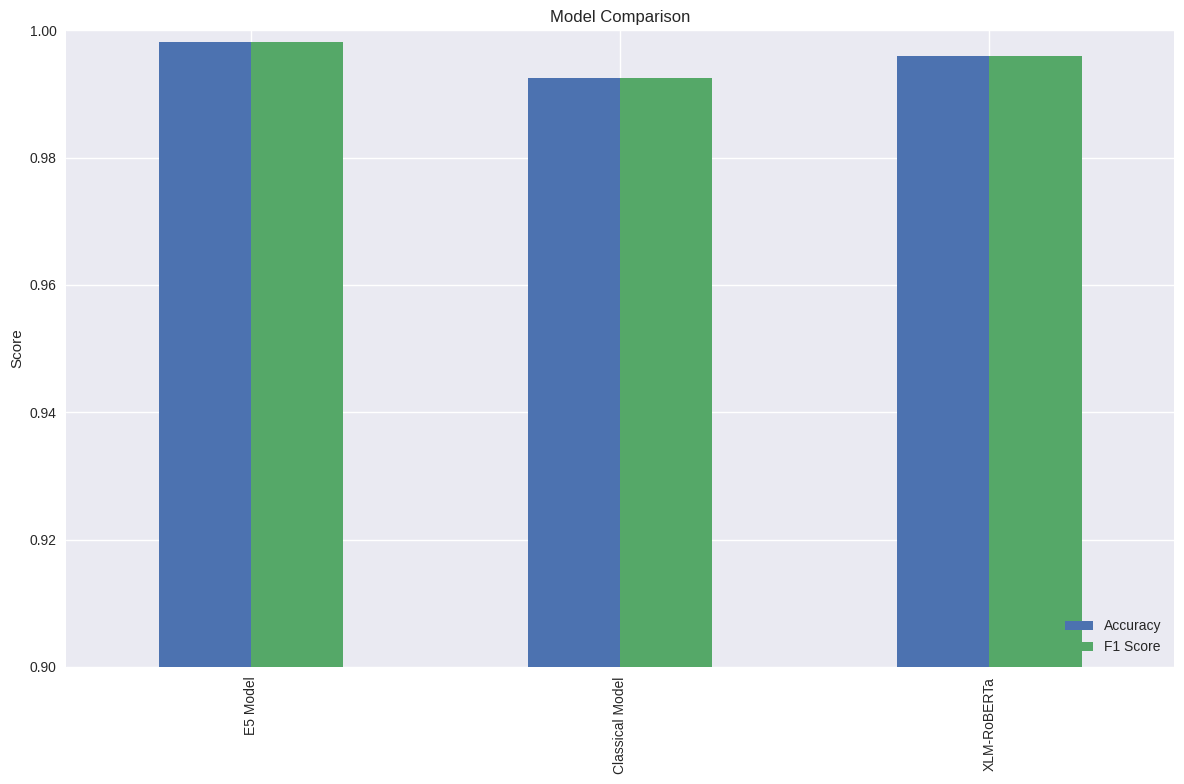

In [13]:
# Compare model results
results = {
    'E5 Model': {'accuracy': accuracy_e5, 'f1_score': f1_e5},
    'Classical Model': {'accuracy': accuracy_classical, 'f1_score': f1_classical},
    'XLM-RoBERTa': {'accuracy': accuracy_xlm, 'f1_score': f1_xlm}
}

def compare_models(results):
    models = list(results.keys())
    metrics = ['Accuracy', 'F1 Score']

    data = []
    for model in models:
        data.append([results[model]['accuracy'], results[model]['f1_score']])

    df = pd.DataFrame(data, columns=metrics, index=models)

    plt.figure(figsize=(12, 6))
    df.plot(kind='bar', ylim=(0.9, 1))
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

compare_models(results)


## Confusion Matrix Visualization
To get a better understanding of model performance, we will plot the confusion matrices for each of the models. This helps in identifying the performance per language.


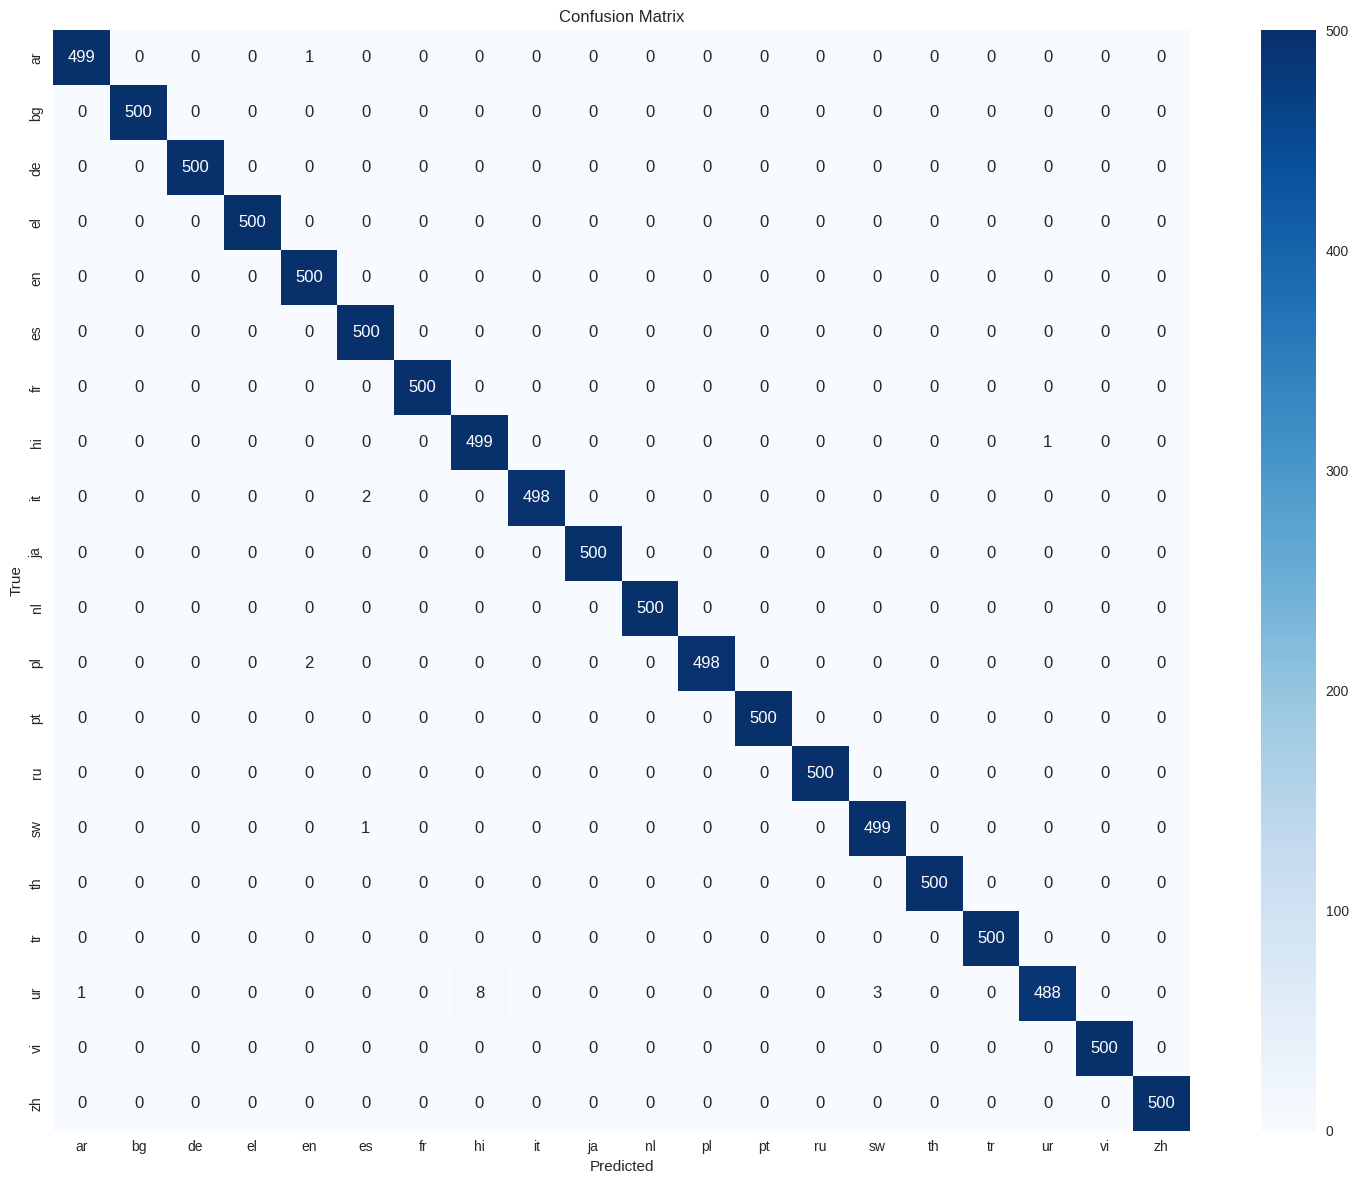

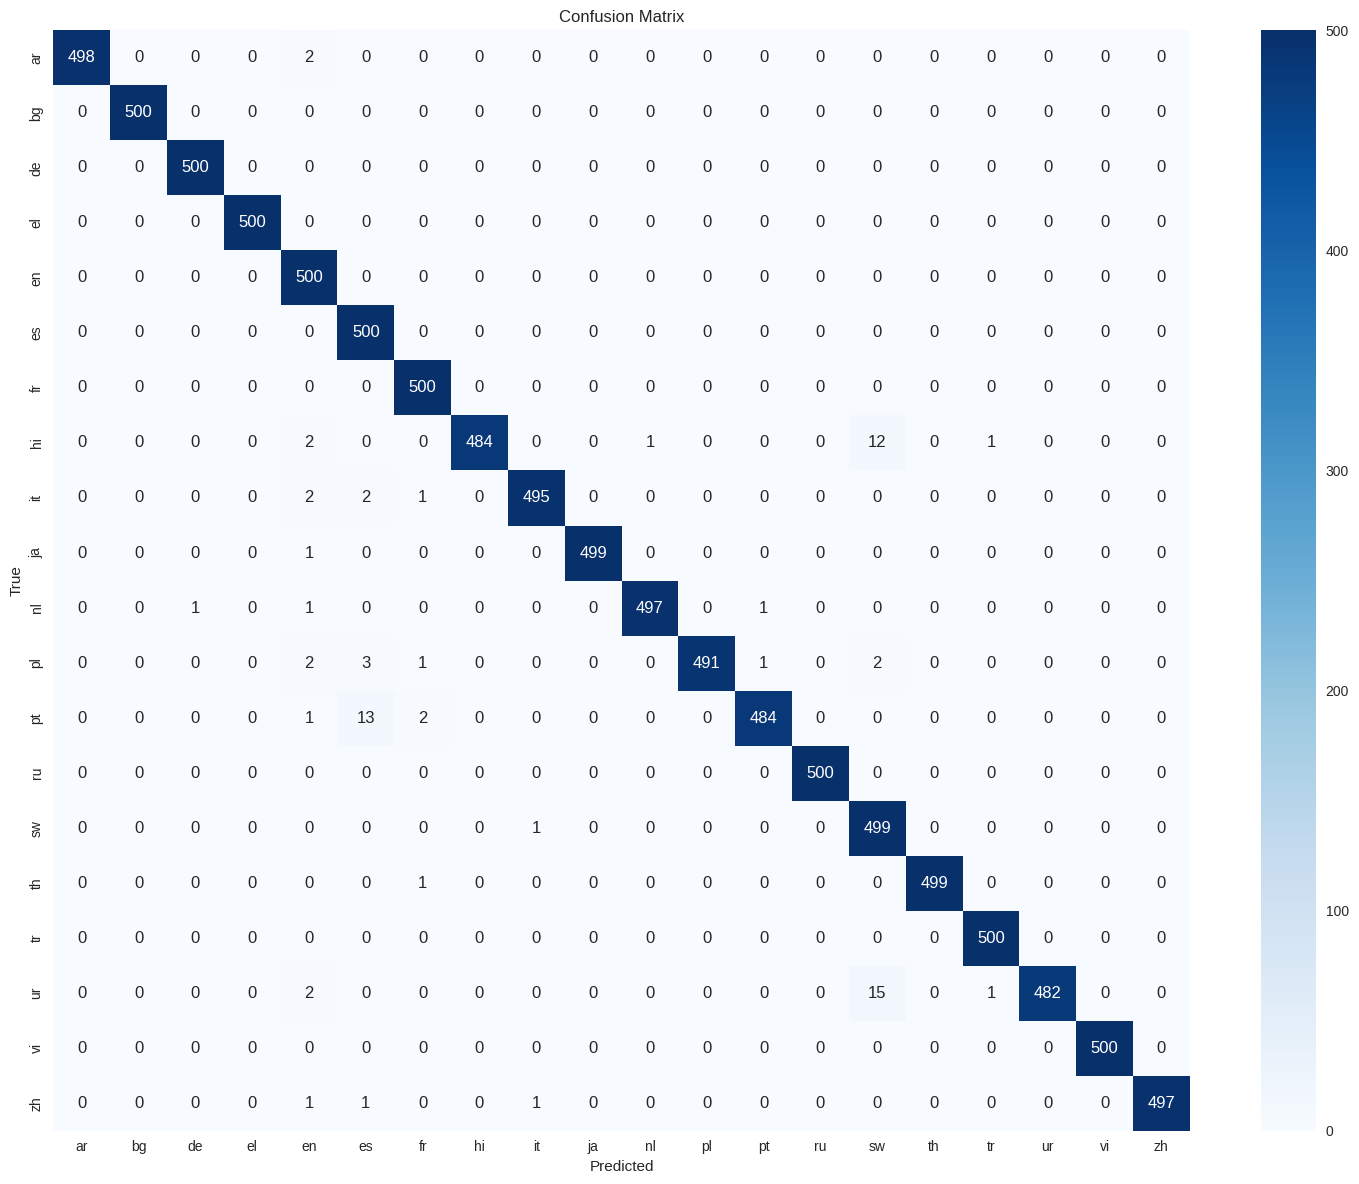

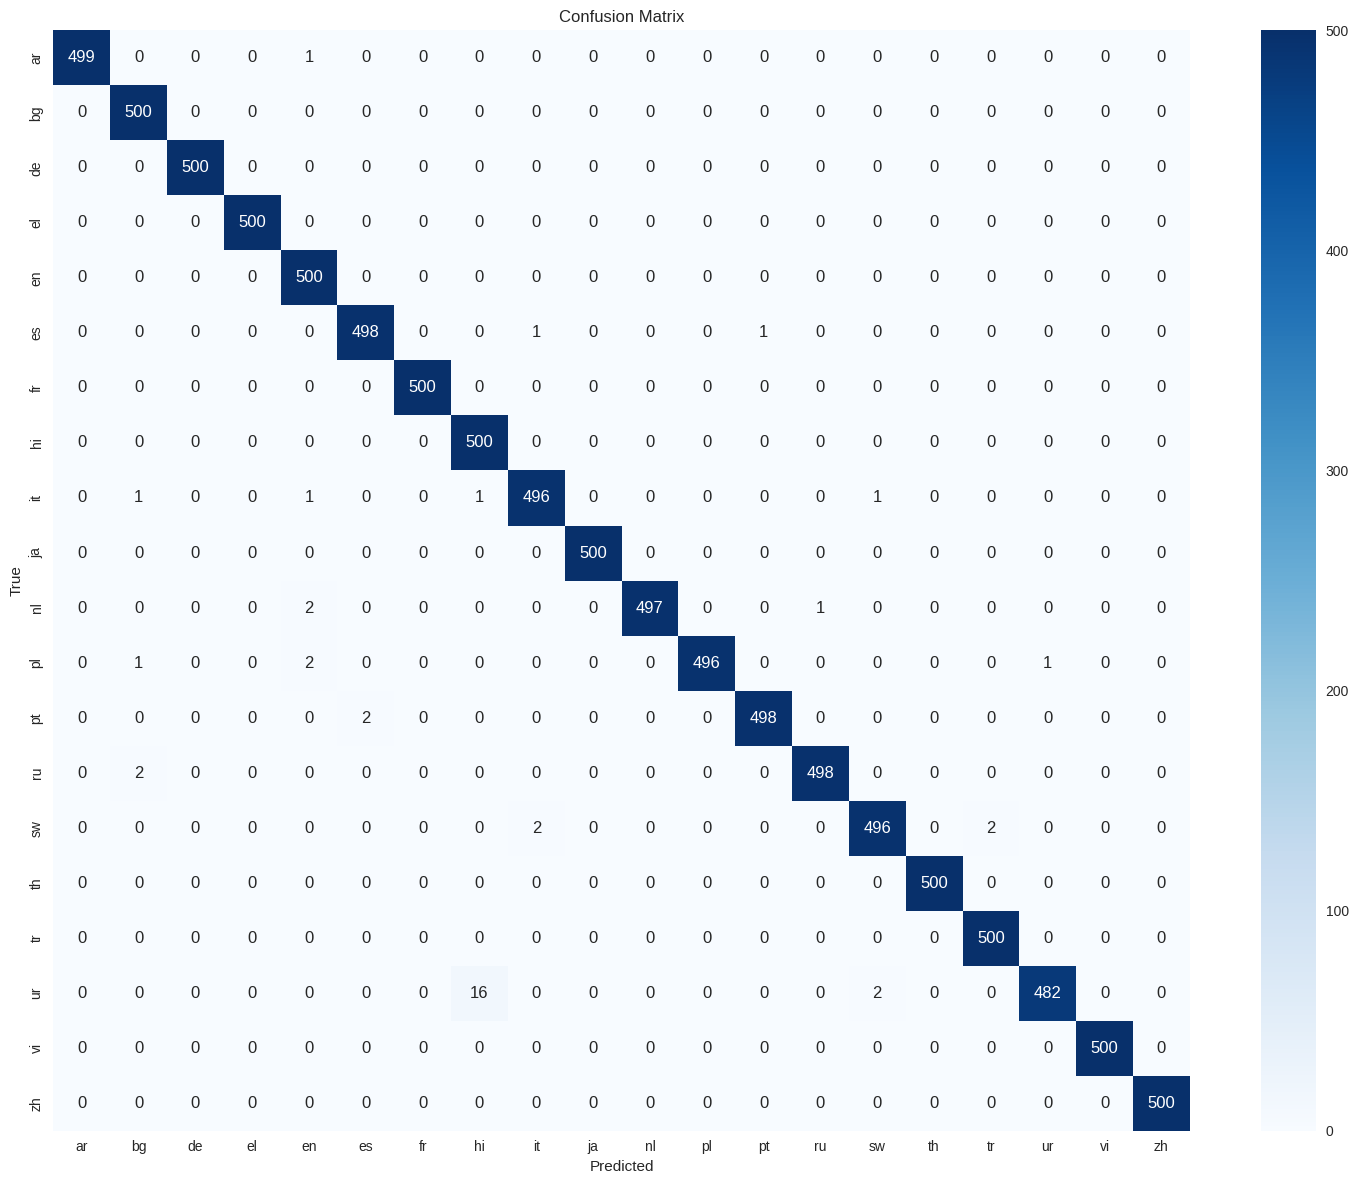

In [14]:
def plot_confusion_matrix(true_labels, pred_labels, label_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=label_names)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Extract true labels from the test dataset
true_labels = ds['test']['labels']

plot_confusion_matrix(true_labels, pred_labels_e5, label_names)
plot_confusion_matrix(true_labels, pred_labels_classical, label_names)
plot_confusion_matrix(true_labels, predictions_xlm, label_names)


## Discussion and Conclusion
### Comparative Analysis of Language Detection Models

#### 1. **Introduction**
Language detection is a critical task in natural language processing (NLP) with applications ranging from text preprocessing to multilingual content management. In this report, I presented a comparative analysis of my own approach compared with other two different methodologies for language detection: a state-of-the-art embedding-based approach using the `intfloat/multilingual-e5-large-instruct` model, a classical machine learning model utilizing TFIDF and Multinomial Naive Bayes (MNB) by `imbesat-rizvi/language-identification`, and a fine-tuned transformer model, `papluca/xlm-roberta-base-language-detection`. The benchmarking of the evaluation results is performed on the language identification dataset by `papluca/language-identification`.

#### 2. **Methodology**
The primary approach implemented in this study leverages the `intfloat/multilingual-e5-large-instruct` model, a modern multilingual embedding model trained using contrastive learning. This model was used to compute embeddings for the documents in the training and validation sets of the `papluca/language-identification` dataset. The average embedding for each language was computed, and for each document in the test set, its embedding was compared with the average embeddings of the languages using cosine similarity. The language corresponding to the highest similarity score was assigned to the document.

To benchmark this approach, I compared it against two other models:
1. **Multinomial Naive Bayes (MNB)**: A classical machine learning model implemented using TFIDF vectorization, which transforms text data into numerical features that are then classified using a Multinomial Naive Bayes classifier. The model was implemented using a repository from GitHub `imbesat-rizvi/language-identification` and achieved 99.22% accuracy on the test set.
2. **`papluca/xlm-roberta-base-language-detection`**: A transformer model fine-tuned on the same dataset used in this study. This model, which is based on the XLM-RoBERTa-base architecture, achieved 99.6% accuracy on the test set.

#### 3. **Comparative Analysis**

**3.1. Multinomial Naive Bayes with TFIDF**

- **Algorithm**: The MNB model is a probabilistic classifier that assumes independence between features (i.e., words). The TFIDF vectorizer converts text into numerical features by considering the frequency of terms in a document relative to their frequency in the corpus.
- **Strengths**:
  - **Simplicity and Efficiency**: This model is computationally inexpensive and easy to implement, making it suitable for real-time applications.
  - **Interpretability**: The model's decisions are straightforward to interpret, as they are based on word frequency distributions.
  - **Performance**: Achieves good accuracy (99.22%) on the test set, demonstrating that classical approaches can still be highly effective in controlled environments.
- **Weaknesses**:
  - **Assumption of Independence**: The model assumes that features are independent, which is rarely true in natural language, potentially leading to suboptimal performance.
  - **Limited Generalization**: The model may not generalize well to new or unseen languages since it relies heavily on the specific features present in the languagses in the training data.
  - **Scalability**: As the number of languages increases, the model's performance may degrade due to the increased feature space.

**3.2. `papluca/xlm-roberta-base-language-detection`**

- **Algorithm**: XLM-RoBERTa is a transformer-based model that uses self-attention mechanisms to learn contextualized representations of text. The model was fine-tuned on the `papluca/language-identification` dataset, making it highly specialized for this task.
- **Strengths**:
  - **High Accuracy**: The model achieved 99.6% accuracy, reflecting its ability to capture deep contextual information across multiple languages.
  - **Multilingual Capabilities**: The model is pre-trained on a wide variety of languages, making it robust across diverse linguistic contexts.
  - **Fine-Tuning**: Fine-tuning enhances the model's ability to generalize within the specific domain of the dataset.
- **Weaknesses**:
  - **Computational Cost**: Transformers require significant computational resources, both in terms of memory and processing power, which can be a limitation in production environments.
  - **Overfitting**: Fine-tuning on a specific dataset might lead to overfitting, where the model performs exceptionally well on the test data but may struggle with out-of-domain data or languages not present in the dataset.

**3.3. `intfloat/multilingual-e5-large-instruct` Model**

- **Algorithm**: This model utilizes a contrastive learning approach to generate high-quality embeddings that are multilingual and context-sensitive. By averaging the embeddings for each language and using cosine similarity for classification, this approach is both innovative and effective. This approach's success highly depends on the e5-large-instruct embedding model's ability to differentiate between different languages in the multilingual embedding space.
- **Strengths**:
  - **High Accuracy**: The model achieved the highest accuracy at 99.81%, indicating superior performance in distinguishing between languages in the dataset.
  - **Generalization**: Unlike the fine-tuned XLM-RoBERTa-base model, the `intfloat/multilingual-e5-large-instruct` model was not fine-tuned on the `papluca/language-identification` dataset. It is not also pre-trained on this dataset, which is important to avoid the risk of data leakage and potentially improving its ability to generalize to unseen data.
  - **Scalability**: The method can be scaled to other tasks or languages by simply computing or re-computing the average embeddings of the new languages without retraining the model.
- **Weaknesses**:
  - **Dependence on Embedding Quality**: The success of this approach hinges on the quality of the embeddings produced by the `intfloat/multilingual-e5-large-instruct` model. If the embeddings are not sufficiently discriminative, the model’s performance may degrade.
  - **Handling of Edge Cases**: The model may struggle with documents that are very short, contain mixed languages, or are from languages not included in the training set, as it relies on average embeddings that may not capture these nuances, and can struggle with similar languages, e.g., Spanish and Portuguese.
  - **Token Limitations**: The 512-token limit may truncate longer documents, potentially losing important context needed for accurate classification.

#### 4. **Discussion of Limitations and Edge Cases**
The `intfloat/multilingual-e5-large-instruct` model, while highly effective, is not without its limitations. One key issue is its ability to handle languages not present in the training dataset. Since the model relies on precomputed average embeddings, it may not accurately classify documents in languages outside the 20 supported by the `papluca/language-identification` dataset. This can be addressed by puting a threshold on the similarity scores, and classify the document to 'Other' if the maximum similarity is below this threshold. Additionally, documents that exceed the 512-token limit may be truncated, which could lead to incorrect classifications if important context is lost.

In comparison, the `papluca/xlm-roberta-base-language-detection` model, while slightly less accurate, benefits from fine-tuning, which may make it more adaptable to the specific characteristics of the dataset. However, this specialization could also lead to overfitting, making the model less robust when applied to out-of-domain data.

The Multinomial Naive Bayes model, despite its lower accuracy, remains a strong baseline due to its simplicity and efficiency. However, it is less capable of handling the nuances and complexities of language that modern embedding models can capture, particularly in multilingual settings.

#### 5. **Conclusion**
The comparative analysis demonstrates that the `intfloat/multilingual-e5-large-instruct` model offers a compelling balance of accuracy, generalization, and scalability, making it a strong candidate for language detection tasks. The model’s ability to generalize across languages by computing their average embeddings without re-training enhances its applicability to a broader range of scenarios.

However, it is important to acknowledge the limitations of this approach, particularly in handling languages outside the training set and the potential impact of the 512-token limit. Future work could explore hybrid models that combine the strengths of embedding-based and fine-tuned transformer models or extend the approach to include a broader range of languages.

Overall, this approach highlights the potential of modern multilingual embedding models in advancing language detection, while also emphasizing the importance of careful model selection and evaluation in ensuring robust and generalizable results.



## References
- Papluca, Language Identification Dataset: [https://huggingface.co/datasets/papluca/language-identification](https://huggingface.co/datasets/papluca/language-identification)
- Multilingual-E5-Large-Instruct Model: [https://huggingface.co/intfloat/multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct)
- XLM-RoBERTa-Base-Language-Detection Model: [https://huggingface.co/papluca/xlm-roberta-base-language-detection](https://huggingface.co/papluca/xlm-roberta-base-language-detection)
- Multinomial Naive Bayes Language Identification by Rizvi: [https://github.com/imbesat-rizvi/language-identification](https://github.com/imbesat-rizvi/language-identification)
